In [1]:
!pip install xanfis shap imbalanced-learn xgboost joblib matplotlib scikit-learn


     -------------------------------------- 53.2/53.2 kB 273.6 kB/s eta 0:00:00
     -------------------------------------- 544.9/544.9 kB 1.3 MB/s eta 0:00:00
     ------------------------------------ 258.3/258.3 kB 882.9 kB/s eta 0:00:00
     ------------------------------------ 124.9/124.9 MB 661.5 kB/s eta 0:00:00
     ---------------------------------------- 11.2/11.2 MB 1.1 MB/s eta 0:00:00
     -------------------------------------- 52.6/52.6 kB 901.7 kB/s eta 0:00:00
     -------------------------------------- 216.0/216.0 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 397.9/397.9 kB 2.1 MB/s eta 0:00:00
     -------------------------------------- 307.7/307.7 kB 2.1 MB/s eta 0:00:00
     -------------------------------------- 13.0/13.0 MB 633.0 kB/s eta 0:00:00
     ---------------------------------------- 43.9/43.9 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 974.5 kB/s eta 0:00:00
  Attempting uninstall: typing-extension

In [1]:
# === SETUP ===
import os
import json
import numpy as np
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
from imblearn.over_sampling import SMOTE
from xanfis import GdAnfisClassifier, Data


In [2]:
csv_files = [
    'botnet_ares.csv', 'ddos_iot.csv', 'dos_golden_eye.csv', 'dos_hulk.csv', 'dos_slowhttptest.csv',
    'dos_slowloris.csv', 'friday_benign.csv', 'ftp_patator.csv', 'heartbleed.csv', 'monday_benign.csv',
    'portscan.csv', 'ssh_patato-new.csv', 'thursday_benign.csv', 'tuesday_benign.csv', 'web_brute_force.csv',
    'web_sql_injection.csv', 'web_xss.csv', 'wednesday_benign.csv'
]

dataframes = []
for file in csv_files:
    if os.path.exists(file):
        df = pd.read_csv(file)
        df.columns = df.columns.str.strip()
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)

In [3]:
 #Combine all dataframes
combined_df = pd.concat(dataframes, ignore_index=True)
print(f"Combined dataset shape: {combined_df.shape}")

# Preprocess: Handle column inconsistencies and label encoding
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

if 'label' not in combined_df.columns:
    raise ValueError("Label column not found")

combined_df['label'] = combined_df['label'].str.strip()
combined_df['label'] = combined_df['label'].apply(lambda x: 0 if x == 'Benign' else 1)

print("Class distribution:", combined_df['label'].value_counts(normalize=True))
if combined_df['label'].value_counts(normalize=True).min() < 0.1:
    print("Significant class imbalance detected. Applying SMOTE.")

# Replace infinite values with NaN
combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separate features and target
X = combined_df.drop('label', axis=1)
y = combined_df['label']

# Handle non-numeric columns
non_numeric_cols = ['Flow ID', 'Timestamp', 'Src IP', 'Dst IP', 'Protocol']  # From previous conversation
for col in X.columns:
    if col in non_numeric_cols:
        X = X.drop(col, axis=1)  # Drop non-informative columns
    else:
        X[col] = pd.to_numeric(X[col], errors='coerce')

Combined dataset shape: (2432103, 122)
Class distribution: 0    0.734442
1    0.265558
Name: label, dtype: float64


In [4]:
# === STEP: Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp)



In [5]:
# === STEP: Feature selection with XGBoost
xgb_selector = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=4, max_depth=6)
xgb_selector.fit(X_train, y_train)
importances = xgb_selector.feature_importances_
selected_indices = np.argsort(importances)[::-1][:10]
selected_features = X.columns[selected_indices].tolist()

# Save selected features
os.makedirs('model_files', exist_ok=True)
with open('model_files/selected_features.json', 'w') as f:
    json.dump({'features': selected_features}, f)

# Subset based on selected features
X_train = X_train[selected_features]
X_val   = X_val[selected_features]
X_test  = X_test[selected_features]

# === STEP: Impute + scale
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_val   = scaler.transform(imputer.transform(X_val))
X_test  = scaler.transform(imputer.transform(X_test))

joblib.dump(imputer, 'model_files/imputer.joblib')
joblib.dump(scaler, 'model_files/scaler.joblib')

# === STEP: Balance only the training set
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)


C:\Users\CornelMedia\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\CornelMedia\anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [6]:
# === STEP: Train XGBoost on balanced training set
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=6,
    n_jobs=4,
    random_state=42
)
xgb_model.fit(X_train_bal, y_train_bal)

# Save model
joblib.dump(xgb_model, 'model_files/xgb_model.joblib')



C:\Users\CornelMedia\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [08:16:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['model_files/xgb_model.joblib']

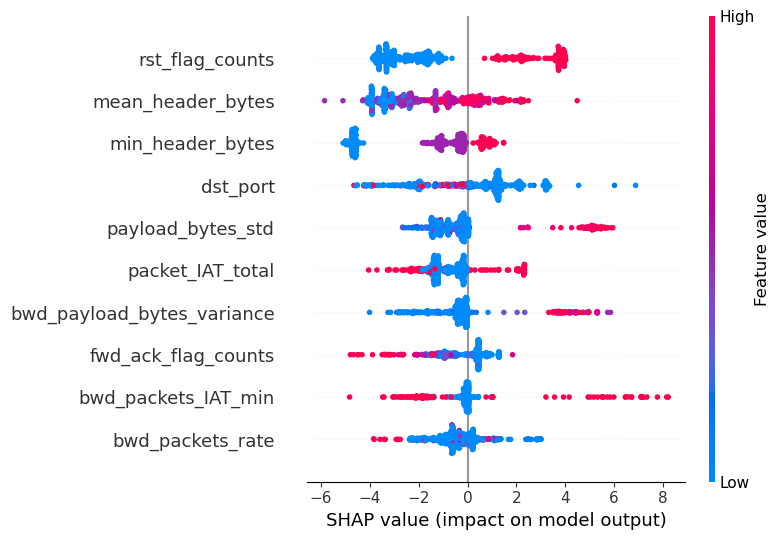

In [7]:
# === STEP: SHAP Explanation (on validation sample)
explainer = shap.TreeExplainer(xgb_model)

# Sample from validation set (unbalanced, original features)
val_indices = np.random.choice(len(X_val), size=min(500, len(X_val)), replace=False)
X_val_sample = X_val[val_indices]

shap_vals = explainer.shap_values(X_val_sample)

# Save SHAP explainer and values
joblib.dump(explainer, 'model_files/shap_explainer.joblib')
joblib.dump(shap_vals, 'model_files/shap_values_val.joblib')

# === STEP: SHAP Visualizations
shap.initjs()

# 1. Global summary plot
shap.summary_plot(shap_vals, X_val_sample, feature_names=selected_features)

# 2. Local force plot for first instance
shap.force_plot(
    explainer.expected_value, shap_vals[0], X_val_sample[0], feature_names=selected_features
)


In [13]:
from sklearn.utils import resample

# 🔹 Subsample the SMOTE-balanced training data
X_train_anfis, y_train_anfis = resample(
    X_train_bal, y_train_bal,
    n_samples=1000000, random_state=42, stratify=y_train_bal
)

# 🔹 Define and train the ANFIS model
anfis_model = GdAnfisClassifier(
    num_rules=4,               # Reasonable complexity
    mf_class='Gaussian',
    epochs=20,                 # Won't run forever
    batch_size=128,            # Speeds up training
    optim='Adam',
    optim_params={'lr': 1e-2},
    early_stopping=True,
    n_patience=3,
    valid_rate=0.1,
    verbose=True
)

anfis_model.fit(X_train_anfis, y_train_anfis)

# Save
joblib.dump(anfis_model, 'model_files/anfis_xanfis.joblib')


Epoch: 1, Train Loss: 0.556272, Validation Loss: 0.550248
Epoch: 2, Train Loss: 0.550406, Validation Loss: 0.549225
Epoch: 3, Train Loss: 0.549743, Validation Loss: 0.548791
Epoch: 4, Train Loss: 0.549466, Validation Loss: 0.548535
Epoch: 5, Train Loss: 0.549295, Validation Loss: 0.548412
Epoch: 6, Train Loss: 0.549168, Validation Loss: 0.548667
Epoch: 7, Train Loss: 0.549082, Validation Loss: 0.548296
Epoch: 8, Train Loss: 0.549013, Validation Loss: 0.548251
Epoch: 9, Train Loss: 0.548950, Validation Loss: 0.548098
Epoch: 10, Train Loss: 0.548908, Validation Loss: 0.548050
Epoch: 11, Train Loss: 0.548798, Validation Loss: 0.547963
Epoch: 12, Train Loss: 0.548738, Validation Loss: 0.547927
Epoch: 13, Train Loss: 0.548683, Validation Loss: 0.547921
Epoch: 14, Train Loss: 0.548670, Validation Loss: 0.547873
Epoch: 15, Train Loss: 0.548631, Validation Loss: 0.548155
Epoch: 16, Train Loss: 0.548600, Validation Loss: 0.547767
Epoch: 17, Train Loss: 0.548561, Validation Loss: 0.547771
Epoch:

['model_files/anfis_xanfis.joblib']


--- Classification Report (Meta Learner) ---
              precision    recall  f1-score   support

           0     0.9984    0.9983    0.9983    357248
           1     0.9953    0.9955    0.9954    129173

    accuracy                         0.9975    486421
   macro avg     0.9968    0.9969    0.9969    486421
weighted avg     0.9975    0.9975    0.9975    486421



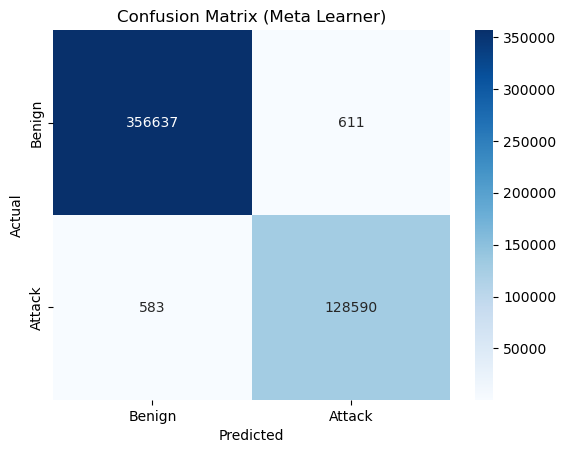


Meta-Learner Test Accuracy: 0.9975


In [16]:

# Predictions
xgb_test_preds   = xgb_model.predict_proba(X_test)[:, 1]               # Class 1 prob (Attack)
anfis_test_preds = anfis_model.predict_proba(X_test).ravel()           # Already gives class 1

# Stack predictions
stacked_test     = np.column_stack((xgb_test_preds, anfis_test_preds))
meta_preds       = meta.predict(stacked_test)

# Classification report
print("\n--- Classification Report (Meta Learner) ---")
print(classification_report(y_test, meta_preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, meta_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Meta Learner)')
plt.show()

# Accuracy
accuracy = (meta_preds == y_test).mean()
print(f"\nMeta-Learner Test Accuracy: {accuracy:.4f}")


In [17]:
from sklearn.metrics import roc_auc_score, f1_score

print(f"ROC AUC: {roc_auc_score(y_test, meta_preds):.4f}")
print(f"F1 Score: {f1_score(y_test, meta_preds):.4f}")


ROC AUC: 0.9969
F1 Score: 0.9954


In [18]:
joblib.dump(anfis_model, 'model_files/nf_model.pth')


['model_files/nf_model.pth']